<a href="https://colab.research.google.com/github/gr3ybr0w/cookbook/blob/master/Machine_Learning/clustering/TensorFlow_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np

https://www.learningtensorflow.com/lesson6/

In [0]:
def create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed):
    np.random.seed(seed)
    slices = []
    centroids = []
    # Create samples for each cluster
    for i in range(n_clusters):
        # Outputs random values from a normal distribution.
        samples = tf.random_normal((n_samples_per_cluster, n_features),
                                   mean=0.0,
                                   stddev=5.0,
                                   dtype=tf.float32,
                                   seed=seed,
                                   name="cluster_{}".format(i))
        current_centroid = (np.random.random((1, n_features)) * embiggen_factor) - (embiggen_factor/2)
        centroids.append(current_centroid)
        samples += current_centroid
        slices.append(samples)
    # Create a big "samples" dataset
    samples = tf.concat(slices, 0, name='samples')
    centroids = tf.concat(centroids, 0, name='centroids')
    return centroids, samples

The way this works is to create n_clusters different centroids at random (using np.random.random((1, n_features))) and using those as the centre points for tf.random_normal. The tf.random_normal function generates normally distributed random values, which we then add to the current centre point. This creates a blob of points around that center. We then record the centroids (centroids.append) and the generated samples (slices.append(samples)). Finally, we create “One big list of samples” using tf.concat, and convert the centroids to a TensorFlow Variable as well, also using tf.concat.

In [0]:
n_features = 2
n_clusters = 3
n_samples_per_cluster = 500
seed = 700
embiggen_factor = 70

np.random.seed(seed)

centroids, samples = create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed)

model = tf.global_variables_initializer()
with tf.Session() as session:
    sample_values = session.run(samples)
    centroid_values = session.run(centroids)

This just sets up the number of clusters and features (I recommend keeping the number of features at 2, allowing us to visualise them later), and the number of samples to generate. Increasing the embiggen_factor will increase the “spread” or the size of the clusters. I chose a value here that provides good learning opportunity, as it generates visually identifiable clusters.

In [0]:
def plot_clusters(all_samples, centroids, n_samples_per_cluster):
    import matplotlib.pyplot as plt
    #Plot out the different clusters
    #Choose a different colour for each cluster
    colour = plt.cm.rainbow(np.linspace(0,1,len(centroids)))
    for i, centroid in enumerate(centroids):
        #Grab just the samples fpr the given cluster and plot them out with a new colour
        samples = all_samples[i*n_samples_per_cluster:(i+1)*n_samples_per_cluster]
        plt.scatter(samples[:,0], samples[:,1], c=colour[i])
        #Also plot centroid
        plt.plot(centroid[0], centroid[1], markersize=35, marker="x", color='k', mew=10)
        plt.plot(centroid[0], centroid[1], markersize=30, marker="x", color='m', mew=5)
    plt.show()

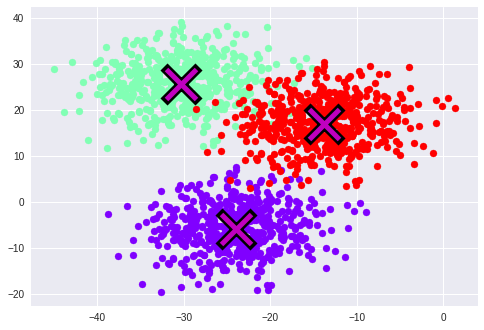

In [24]:
plot_clusters(sample_values, centroid_values, n_samples_per_cluster)

The k-means algorithm starts with the choice of the initial centroids, which are just random guesses of the actual centroids in the data. The following function will randomly choose a number of samples from the dataset to act as this initial guess:

In [0]:
def choose_random_centroids(samples, n_clusters):
    # Step 0: Initialisation: Select 'n_clusters' number of random points
    n_samples = tf.shape(samples)[0]
    random_indices = tf.random_shuffle(tf.range(0, n_samples))
    begin = [0,]
    size = [n_clusters,]
    size[0] = n_clusters
    centroid_indices = tf.slice(random_indices, begin, size)
    initial_centorids = tf.gather(samples, centroid_indices)
    return initial_centorids

After starting with some guess for the centroid locations, the k-means algorithm then updates those guesses based on the data. The process is to assign each sample a cluster number, representing the centroid it is closest to. After that, the centroids are updated to be the means of all samples assigned to that cluster. The following code handles the assign to nearest cluster step:

In [0]:
def assign_to_nearest(samples, centroids):
    # Finds the nearest centroid for each sample

    # START from http://esciencegroup.com/2016/01/05/an-encounter-with-googles-tensorflow/
    expanded_vectors = tf.expand_dims(samples, 0)
    expanded_centroids = tf.expand_dims(centroids, 1)
    distances = tf.reduce_sum( tf.square(
               tf.subtract(expanded_vectors, expanded_centroids)), 2)
    mins = tf.argmin(distances, 0)
    # END from http://esciencegroup.com/2016/01/05/an-encounter-with-googles-tensorflow/
    nearest_indices = mins
    return nearest_indices

Note that I’ve borrowed some code from this page which has a different type of k-means algorithm, and lots of other useful information.

The way this works is to compute the distance between each sample and each centroid, which occurs through the `distances =` line. The distance computation here is the Euclidean distance. An important point here is that `tf.subtract` will automatically expand the size of the two arguments. This means that having our samples as a matrix, and the centroids as a column vector will produce the pairwise subtraction between them. In order to do this, we use `tf.expand_dims` to create an extra dimension for both samples and centroids, forcing this behaviour of `tf.subtract`.

In [0]:
def update_centroids(samples, nearest_indices, n_clusters):
    # Updates the centroid to be the mean of all samples associated with it.
    nearest_indices = tf.to_int32(nearest_indices)
    partitions = tf.dynamic_partition(samples, nearest_indices, n_clusters)
    new_centroids = tf.concat([tf.expand_dims(tf.reduce_mean(partition, 0), 0) for partition in partitions], 0)
    return new_centroids

This code takes the nearest indices for each sample, and grabs those out as separate groups using `tf.dynamic_partition`. From here, we use `tf.reduce_mean` on a single group to find the average of that group, forming its new centroid. From here, we just `tf.concat` them together to form our new centroids.

Now we have the piece in place, we can add these calls to our script (or create a new one):

[[-23.928778  -6.212701]
 [-12.886274  15.84781 ]
 [-29.235247  25.017809]]


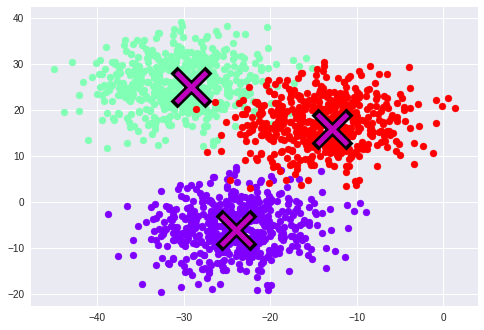

In [30]:
n_features = 2
n_clusters = 3
n_samples_per_cluster = 500
seed = 700
embiggen_factor = 70


data_centroids, samples = create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed)
initial_centroids = choose_random_centroids(samples, n_clusters)
nearest_indices = assign_to_nearest(samples, initial_centroids)
updated_centroids = update_centroids(samples, nearest_indices, n_clusters)

model = tf.global_variables_initializer()
with tf.Session() as session:
    sample_values = session.run(samples)
    updated_centroid_value = session.run(updated_centroids)
    print(updated_centroid_value)

plot_clusters(sample_values, updated_centroid_value, n_samples_per_cluster)